In [122]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.api import STL
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
plt.rcParams['figure.figsize']=(16,8)

In [3]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"], 
    "Monthly Boston armed robberies": robberies_in_boston["Count"], 
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

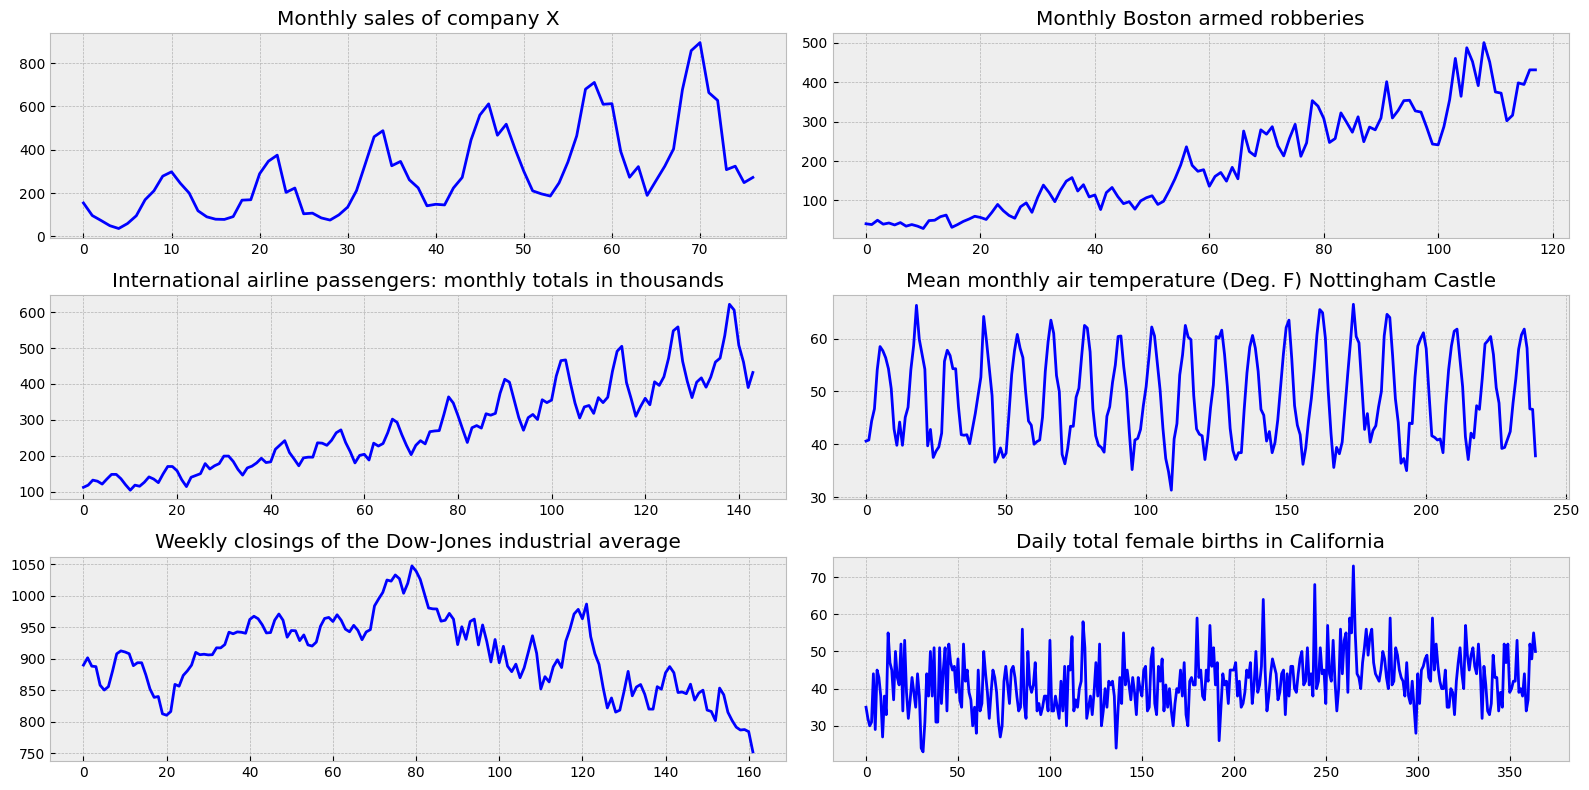

In [26]:
with plt.style.context('bmh'):
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Визуальный анализ
1 - линейный/ растянутый квадратичный тренд, сезонность, период 12 мес., увиличивающаяся дисперсия => у компании увеличиваются продажи, из-за явного тренда и сезонности ряд нестационарен      
2 - возрастающий тренд, нет явной сезонности, увиличивающаяся дисперсия из-за мультипликативности => количество преступлений растет, из-за явнго тренда ряд нестационарен       
3 - возврастающий тренд, сезонность, период 12 мес., дисперсия растет, мультипликативность => все больше людей пользутся международными авиарейсами, из-за явного тренда и сезонности ряд нестационарен     
4 - нет тренда, сезонный, период 12 мес., дисперсия постоянная => в течение времени нету сильных изменений в температуре, похож на стационарный     
5 - тренд рос, потом стал падать, нет явной сезонности, непостоянная дисперсия, поскольку видно, что дисперсия непостоянна предполагаем, что ряд нестационарен     
6 - тренда нет, нет явной сезонности, дисперсия постоянная (возможно есть выбросы), похож на стационарный    

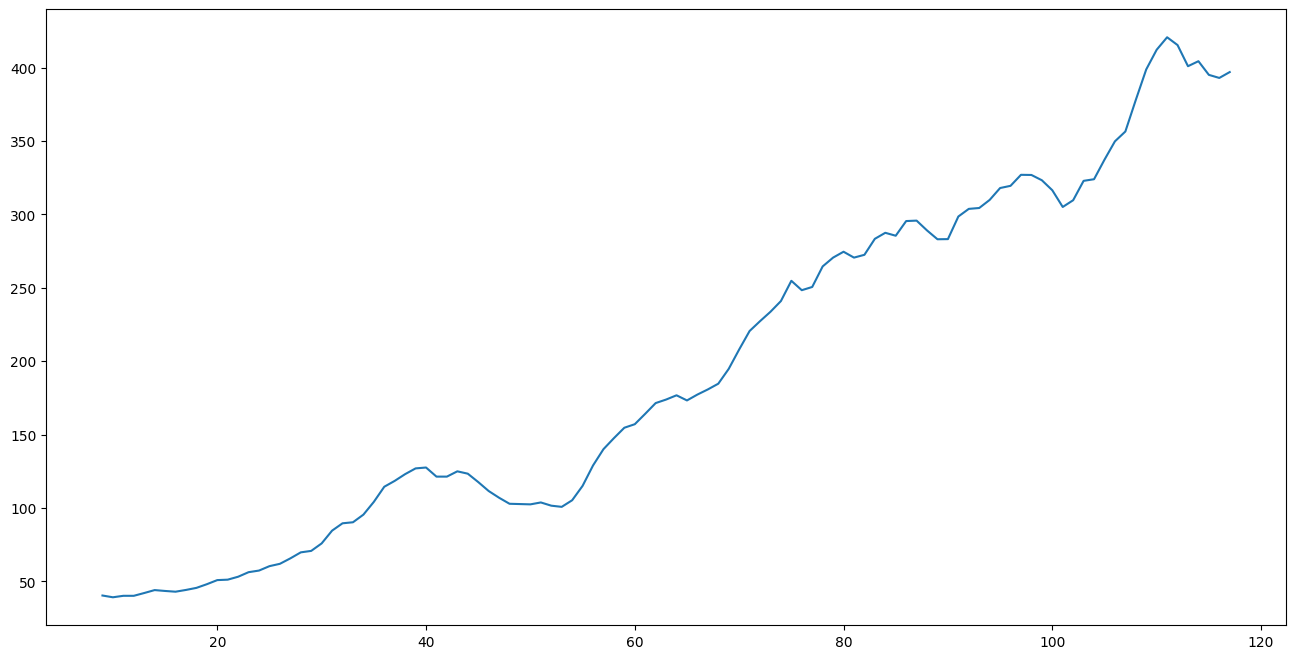

In [29]:
plt.plot(robberies_in_boston['Count'].rolling(window=10).mean())

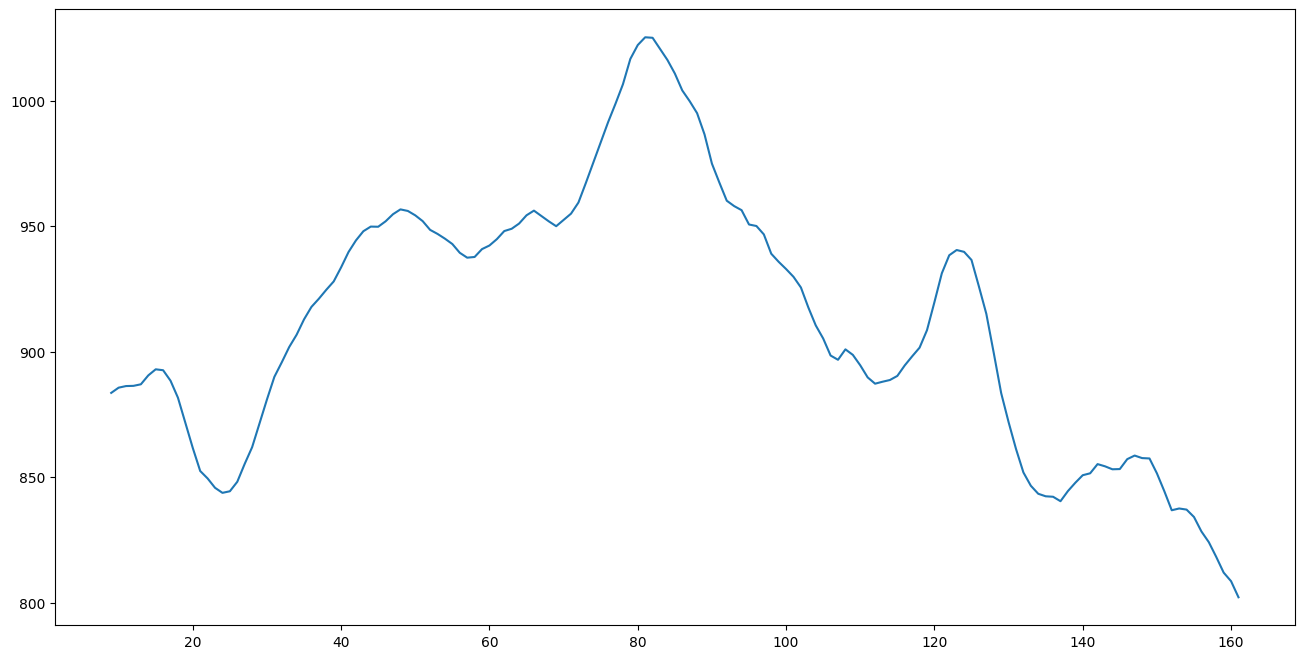

In [30]:
plt.plot(dowjones_closing['Close'].rolling(window=10).mean())

С помощью скользящего среднего сглаживаем график, по нему можно заметить, что сезонности не наблюдается, а значит уровень преступности не зависит от конкретного времени, оно просто постоянно растет. С экономическим показателем похожая ситуация, так как не наблюдается сезонности, конкретной привязки роста или сниджения показателя ко времени также нет. 

Теперь проверим правильно ли мы определили период сезонности    
Для этого используем функции, представленную ниже

In [41]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')
        plt.show()

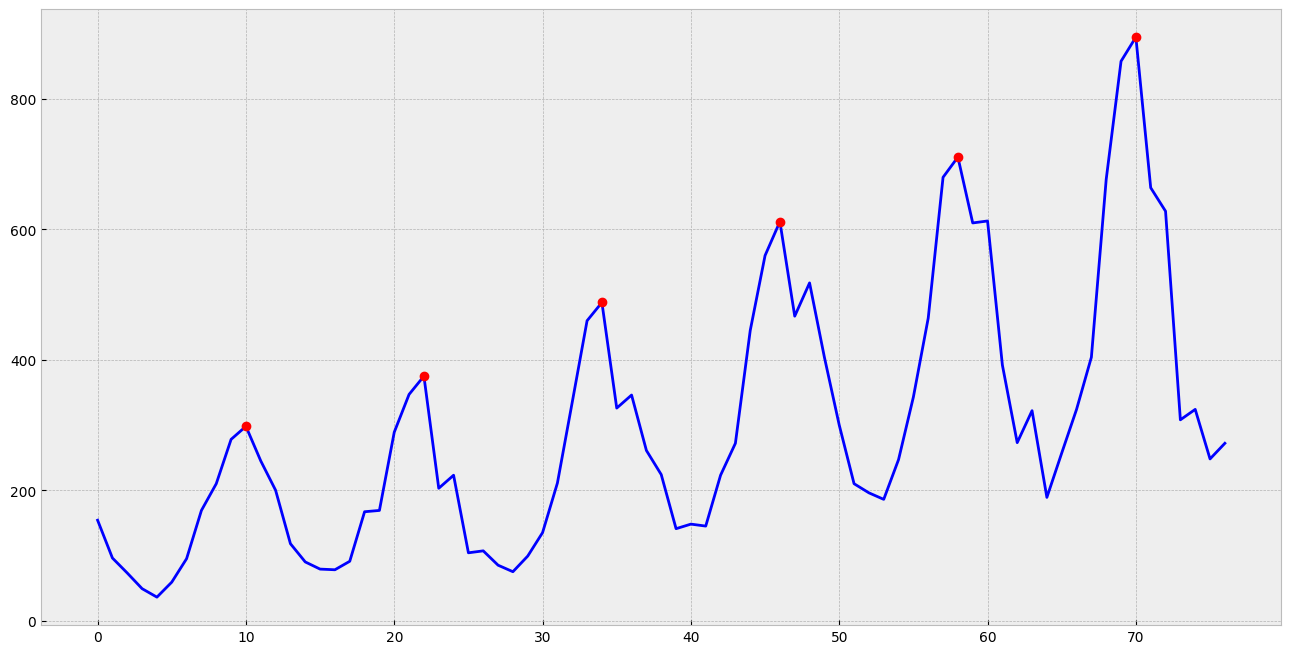

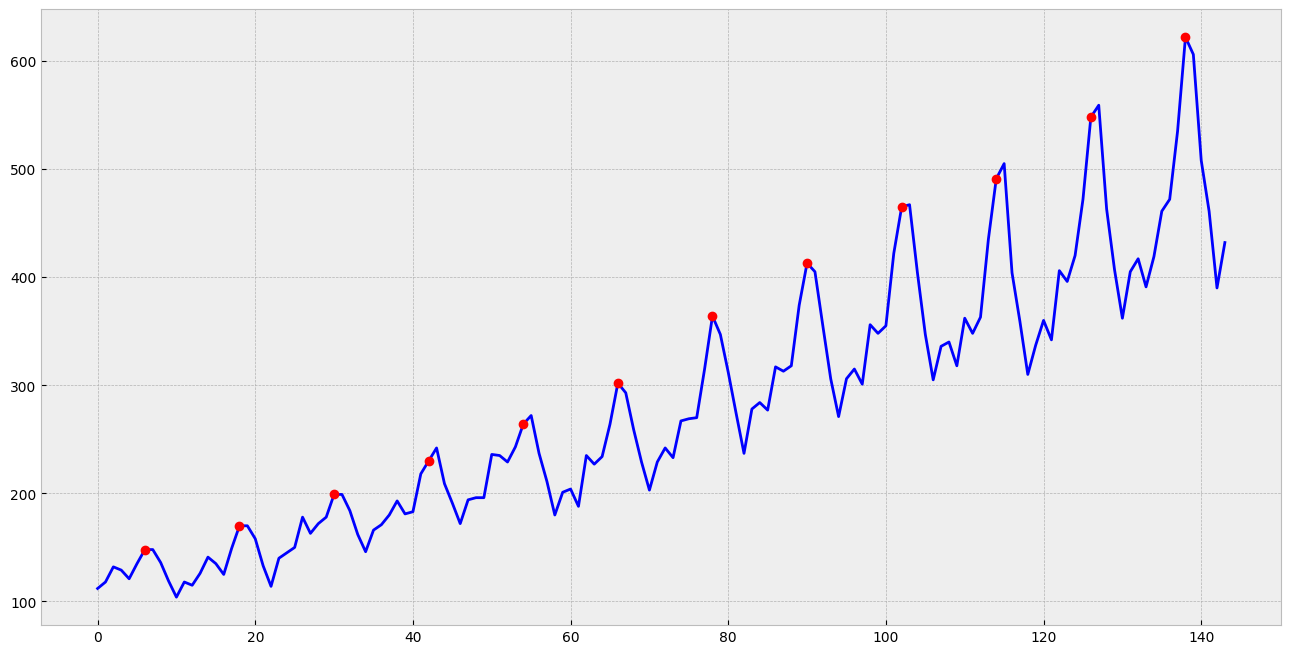

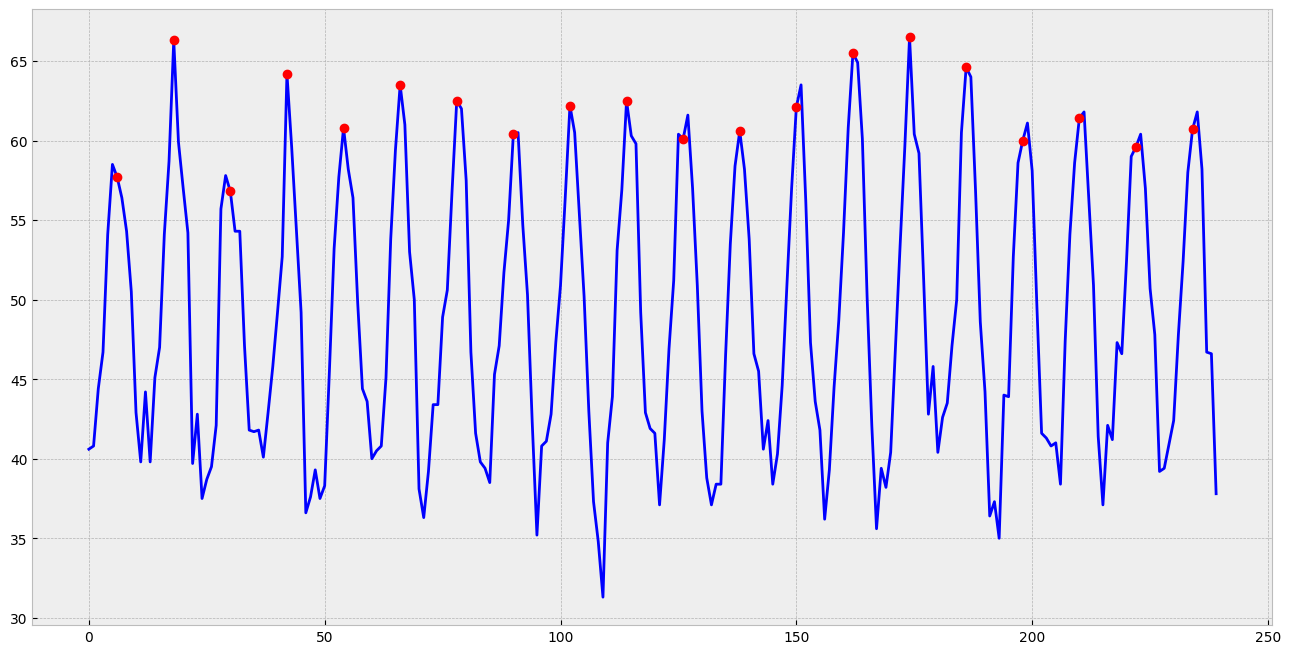

In [43]:
plot_ts_and_points(all_series['Monthly sales of company X'], 10, 12),
plot_ts_and_points(all_series['International airline passengers: monthly totals in thousands'], 6, 12)
plot_ts_and_points(all_series['Mean monthly air temperature (Deg. F) Nottingham Castle'], 6, 12)

Из полученных графиков видно, что сезонность определена правильно

# Нормализуем дисперсию

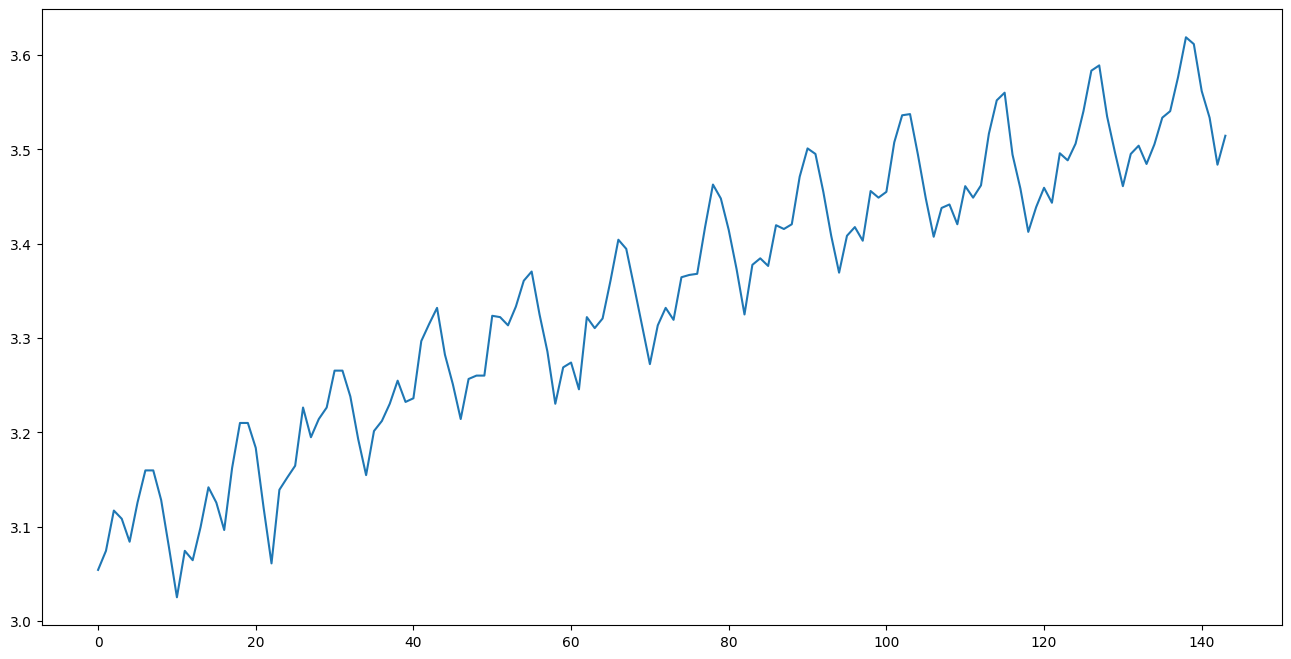

In [77]:
norm_d_airline = boxcox(all_series["International airline passengers: monthly totals in thousands"], -0.2)
plt.plot(norm_d_airline)

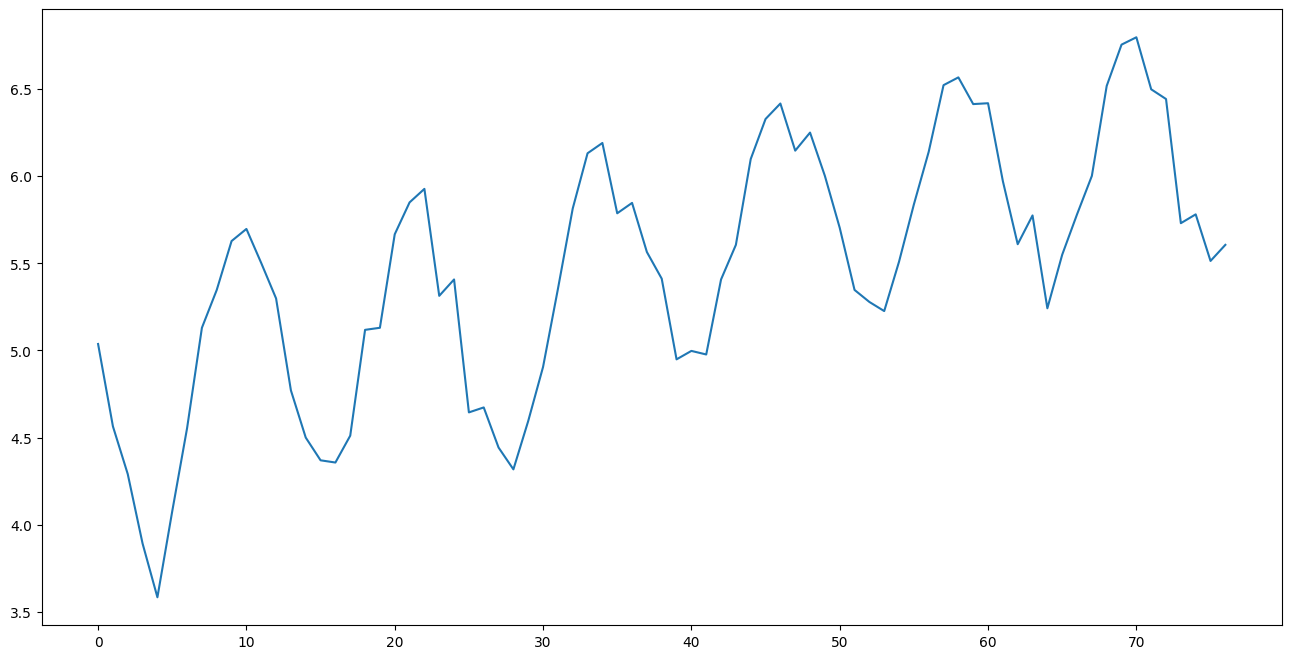

In [63]:
norm_d_sales = boxcox(all_series['Monthly sales of company X'], 0)
plt.plot(norm_d_sales)

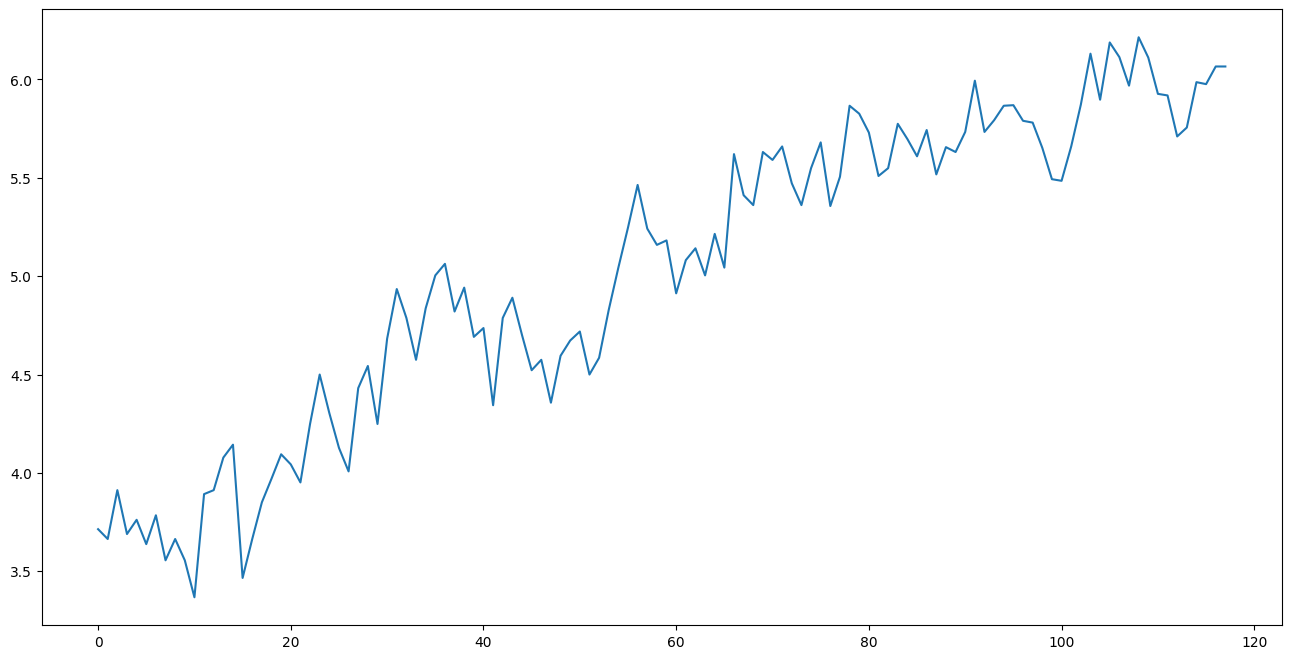

In [82]:
norm_d_robberies = boxcox(all_series['Monthly Boston armed robberies'], 0)
plt.plot(norm_d_robberies)

Более ни с чем преобразование делать на стоит, так как дисперсия монотонна только на первых 3 графиках

# Дифференцируем (переход к попарным разностям его соседних значений)

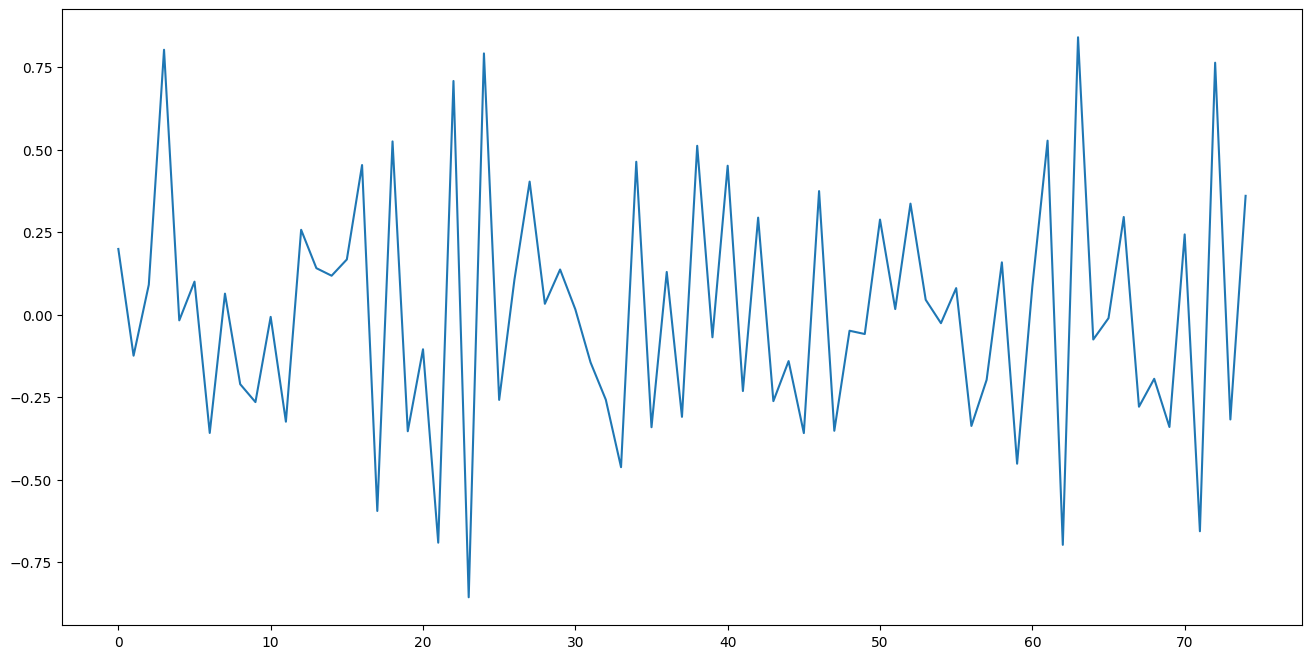

In [136]:
diff_sales = np.diff(norm_d_sales, 2)
plt.plot(diff_sales)

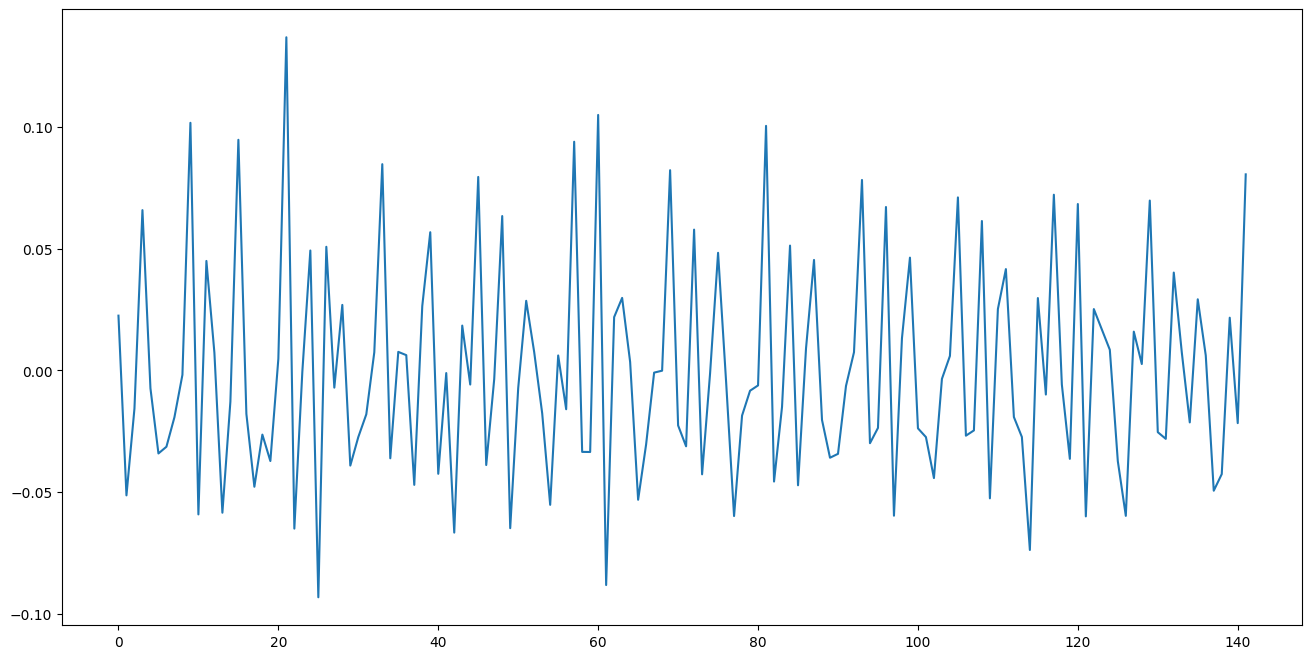

In [133]:
diff_air = np.diff(norm_d_airline, 2)
plt.plot(diff_air)

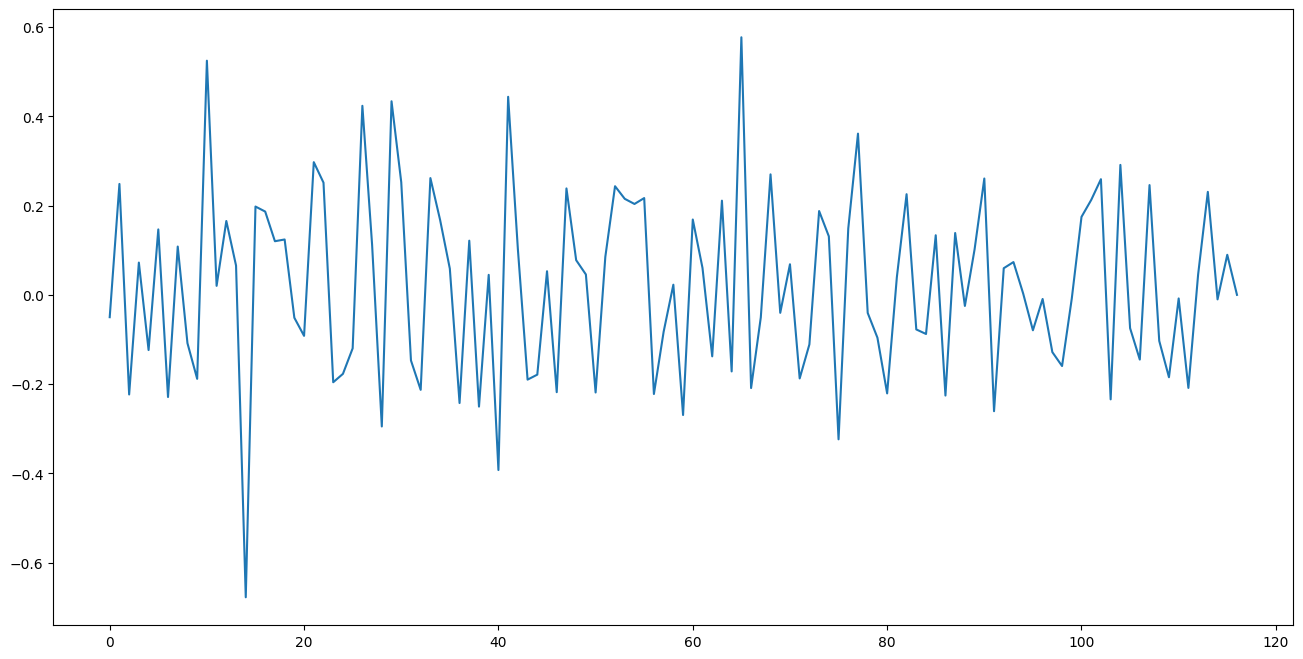

In [99]:
diff_rob = np.diff(norm_d_robberies, 1)
plt.plot(diff_rob)

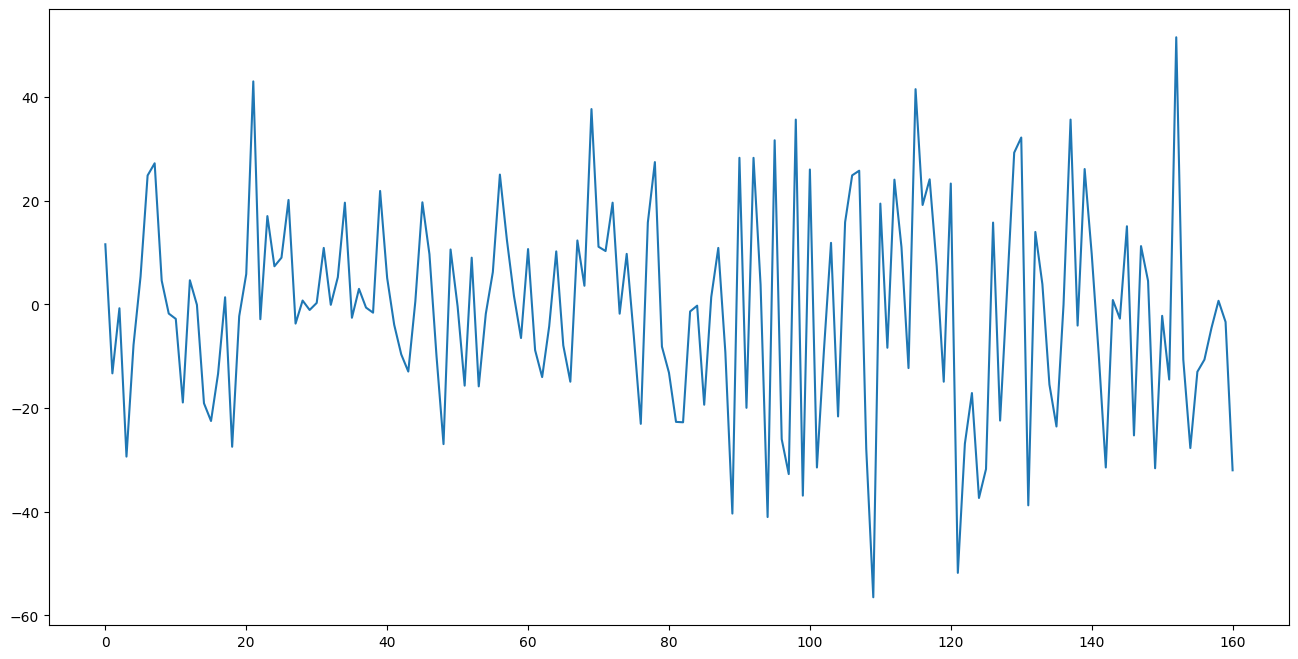

In [111]:
diff_dow = np.diff(all_series['Weekly closings of the Dow-Jones industrial average'], 1)
plt.plot(diff_dow)

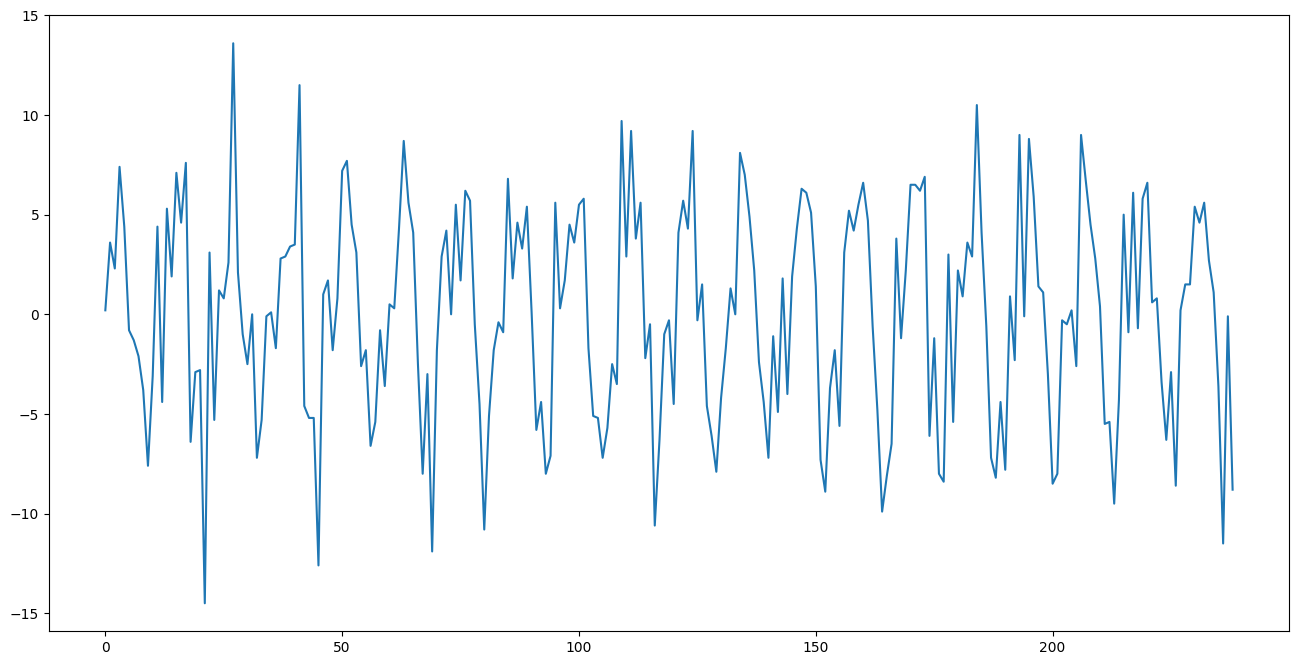

In [148]:
diff_temp = np.diff(all_series['Mean monthly air temperature (Deg. F) Nottingham Castle'], 1)
plt.plot(diff_temp)

По итогам с помощью дифференцирования убрали тренд и сезонность

# Стационарность
## Тест Дики-Фуллера

In [127]:
def get_diki_fuller_stats(ts):
    stats = adfuller(ts)
    print('ADF Statistic: %f' % stats[0])
    print('p-value: %f' % stats[1])
    print('#Lags Used: %f' % stats[2])
    print('Critical Values:')
    for key, value in stats[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

In [152]:
get_diki_fuller_stats(diff_sales)
get_diki_fuller_stats(diff_rob)
get_diki_fuller_stats(diff_air)
get_diki_fuller_stats(diff_temp)
get_diki_fuller_stats(diff_dow)
get_diki_fuller_stats(all_series['Daily total female births in California'])

ADF Statistic: -7.101182
p-value: 0.000000
#Lags Used: 11.000000
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


ADF Statistic: -7.601792
p-value: 0.000000
#Lags Used: 3.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581


ADF Statistic: -8.325613
p-value: 0.000000
#Lags Used: 13.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


ADF Statistic: -12.259271
p-value: 0.000000
#Lags Used: 11.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


ADF Statistic: -13.025208
p-value: 0.000000
#Lags Used: 0.000000
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


ADF Statistic: -4.808291
p-value: 0.000052
#Lags Used: 6.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571




По итогам теста Дики-Фуллера видно, что при диффиренцировании 1 раз 3 из 5 рядов полностью отрицают 0 гипотезу, что говорит об их стационарности, еще 2 графика (1 и 3) пришлось диффиренцировать еще раз, после чего они также прошли тест на стационарность, скорее всего связано это с тем, что на них присутствуют и сезонность, и тернд. Как и предполагалось ранее ряд с ежедневным рождением оказался изначально стационарным.

In [139]:
# Для примера проведем тест Дики-Фуллера для изначальных рядов с сезонностью и трендом (ряд 1 и 3)
get_diki_fuller_stats(all_series['Monthly sales of company X'])
get_diki_fuller_stats(all_series['International airline passengers: monthly totals in thousands'])

ADF Statistic: 0.654715
p-value: 0.988889
#Lags Used: 12.000000
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591


ADF Statistic: 0.815369
p-value: 0.991880
#Lags Used: 13.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579




Почти полная уверенность в 0 гипотезе, что говорит об их нестационарности

In [145]:
def tsplot(y, title, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original ' + title)
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

# Коррелограммы

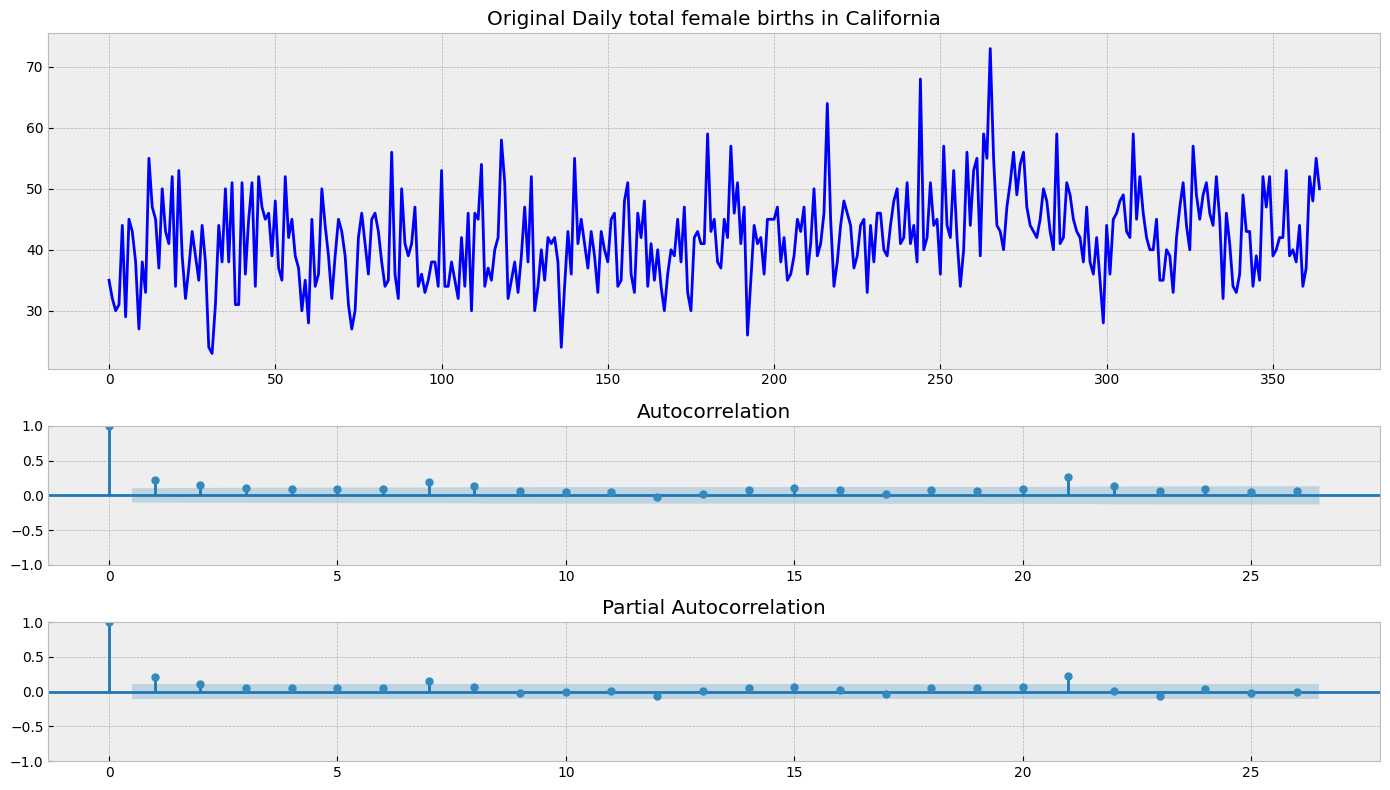

In [146]:
tsplot(all_series['Daily total female births in California'], 'Daily total female births in California')

На графике автокорреляции имеются выбросы в 1, 2, 7, 8 и 21 месяцах

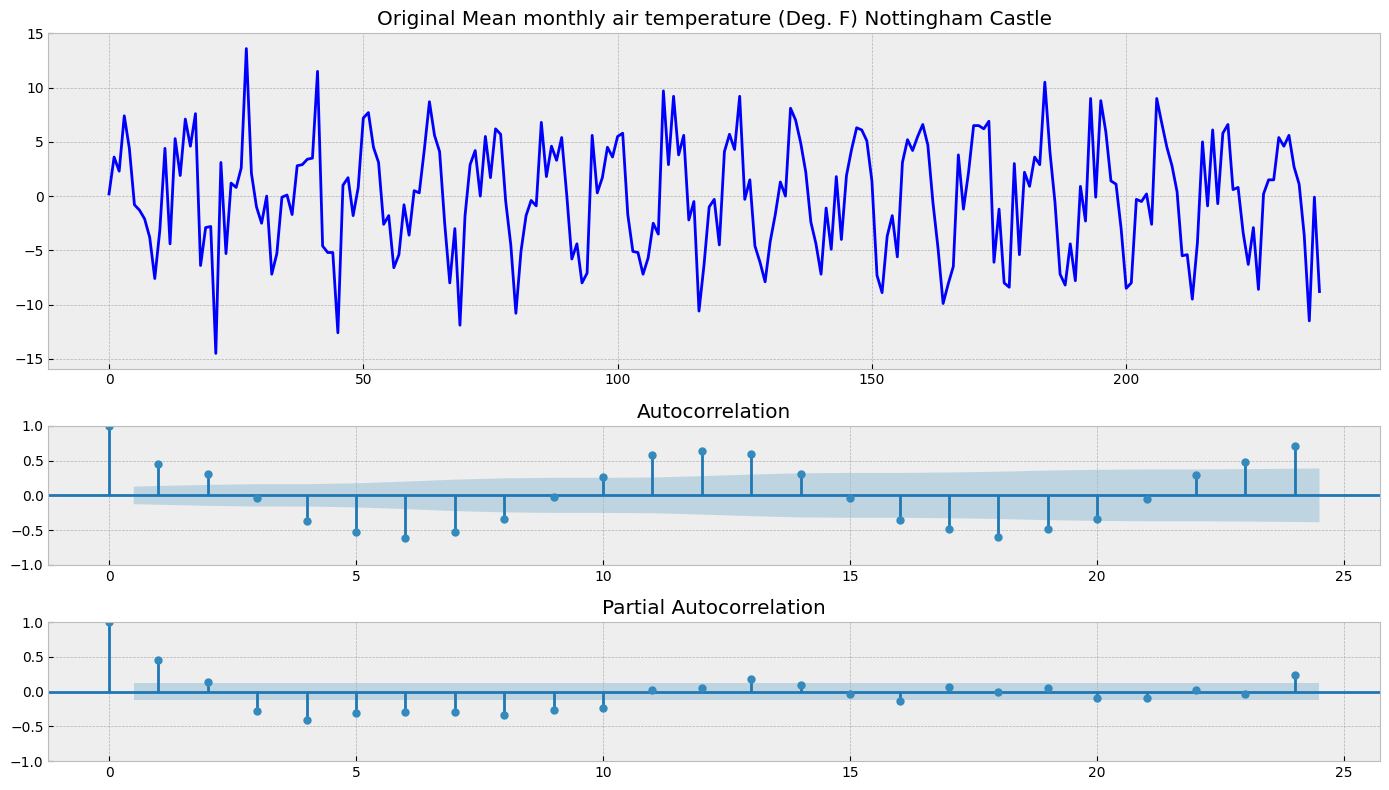

In [151]:
tsplot(diff_temp, 'Mean monthly air temperature (Deg. F) Nottingham Castle')

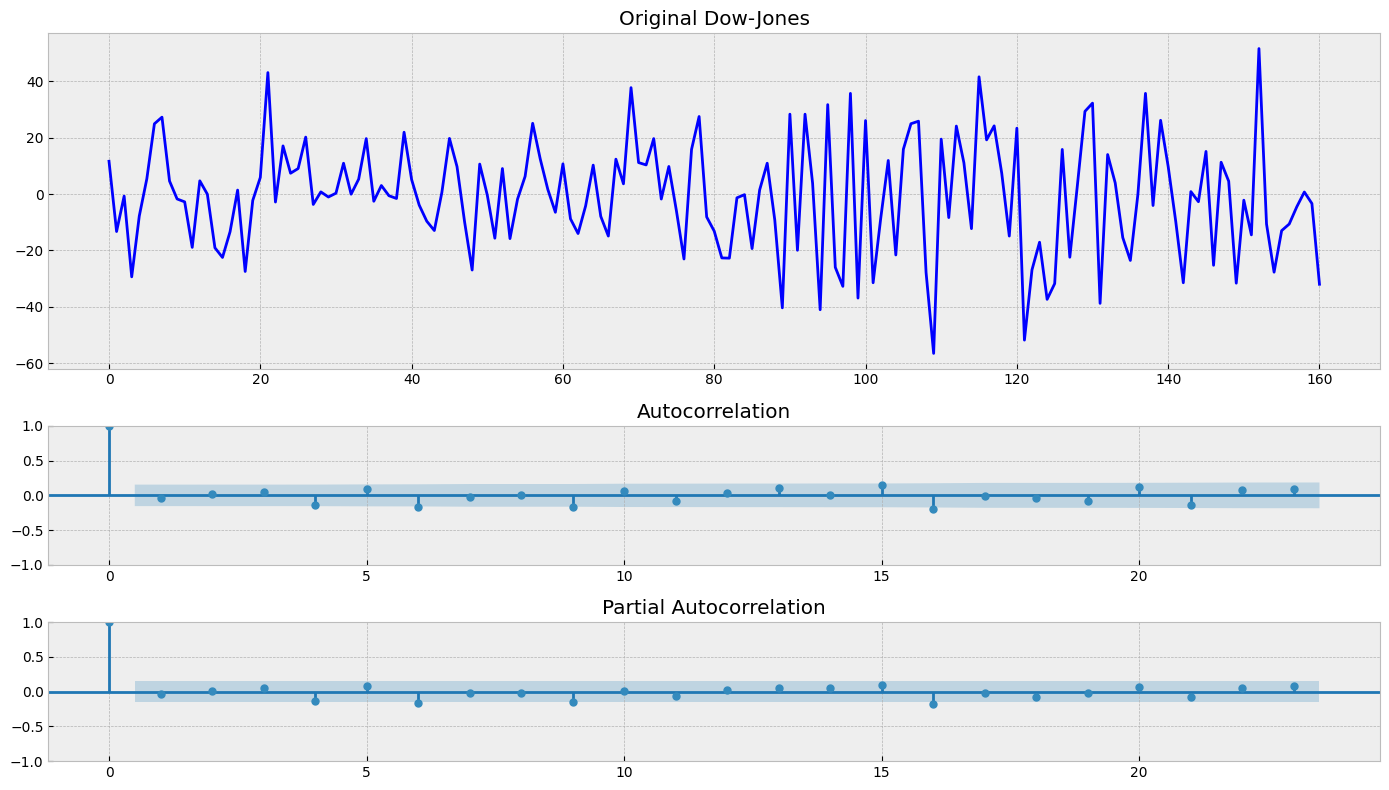

In [153]:
tsplot(diff_dow, 'Dow-Jones')

В диффиренцированном ряде показателя Dow-Jones имеется 4 очень слабых выброса - 4, 6, 9 и 16

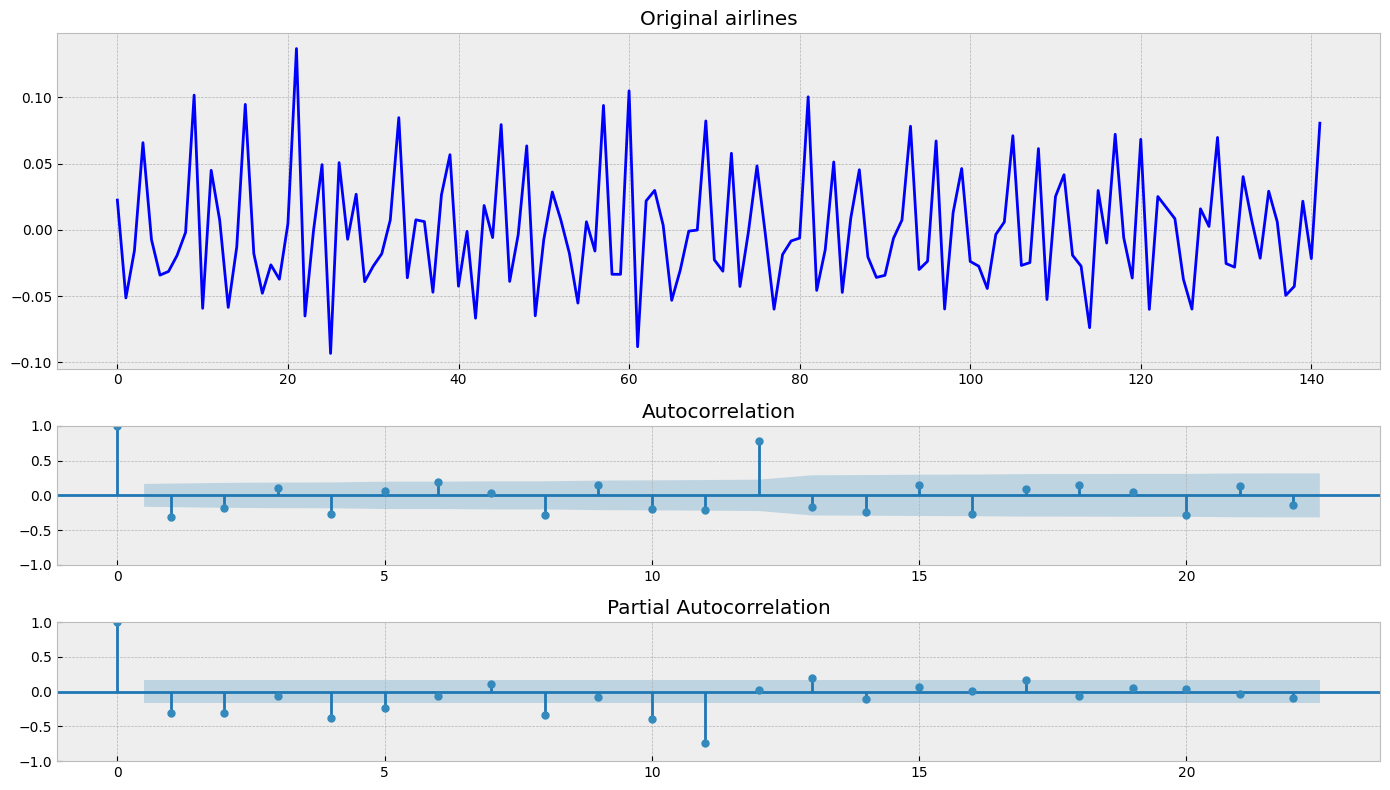

In [154]:
tsplot(diff_air, 'airlines')

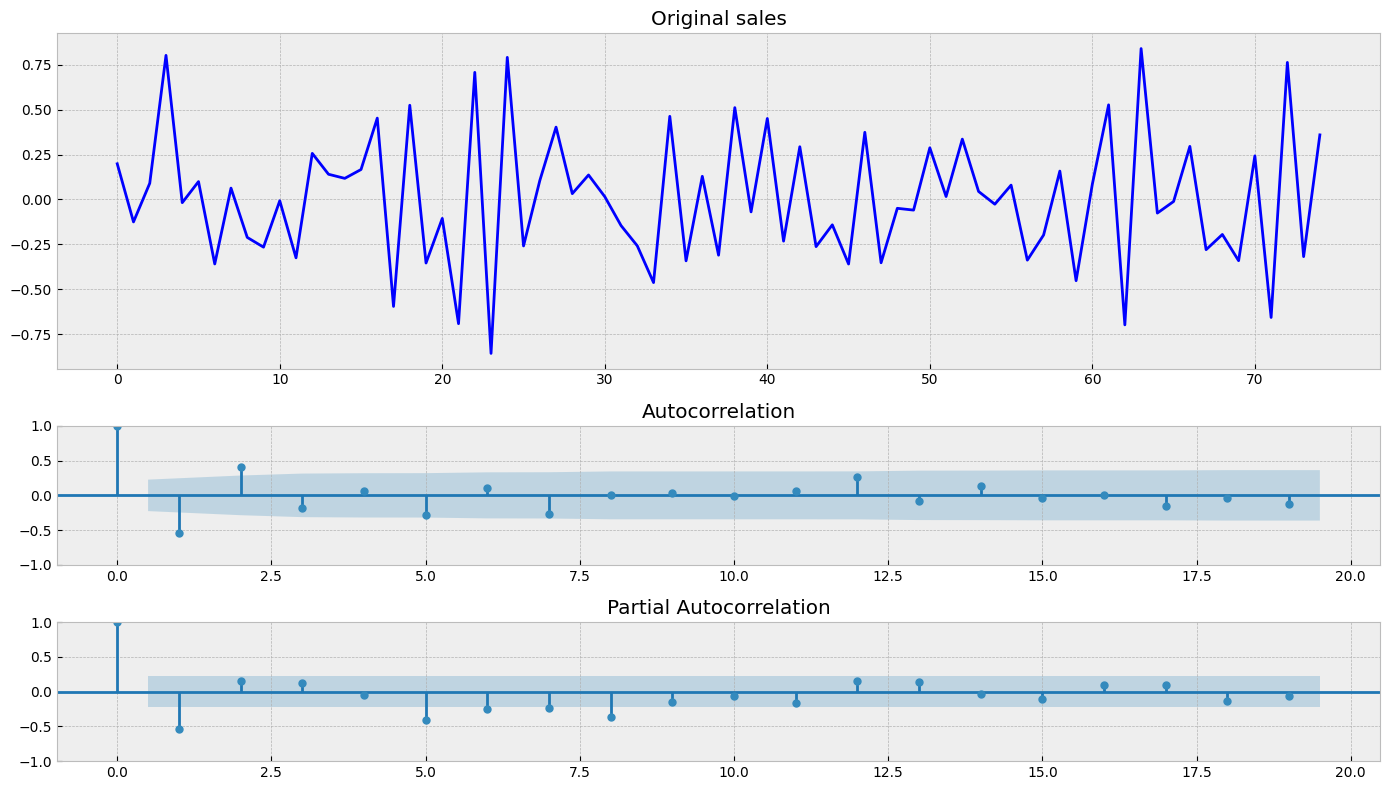

In [155]:
tsplot(diff_sales, 'sales')

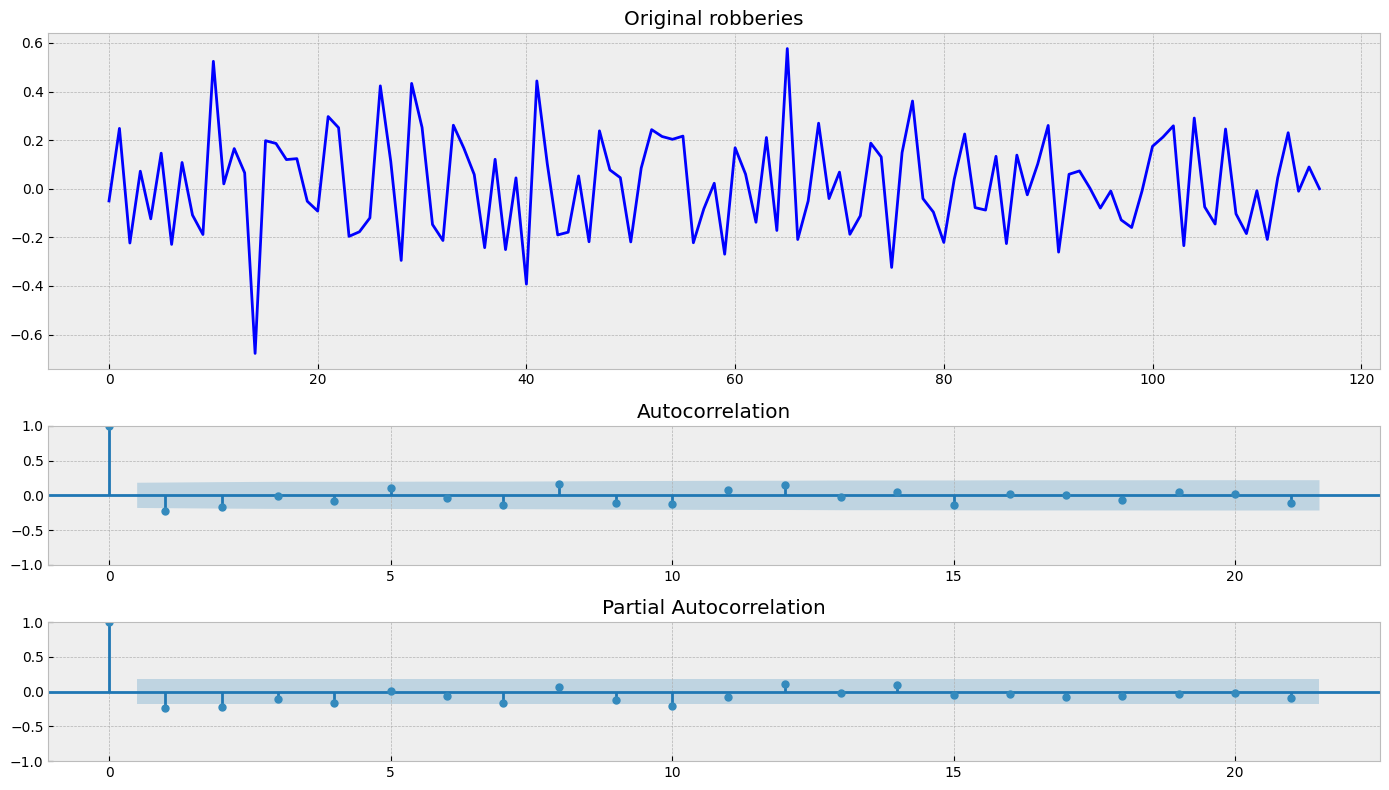

In [156]:
tsplot(diff_rob, 'robberies')